# Task 04 - Pré Processamento e Limpeza dos Dados

Sub-tarefas:
- Codificação (encoding) dos dados.
- Escalonamento dos dados.
- Regras de negócio para limpar dados.

Definição de pronto:

- Datasets de treino e testes preprocessados


Como visto na Task 01 (Análise Exploratória de Dados), todos os dados são numéricos e estão preenchidos. Logo não há necessidade de codificação de atributos categórios e preenchimento de valores faltantes. 

A respeito dos outliers e valores extremos, este problema de classificação se trata em certa instância de uma identificação de anomalias (bebês com risco de saúde). Sendo assim, valores outliers podem ajudar a identificar padrões fora do comportamento normal esperado. 

O escalonamento dos dados será feito durante a etapa de validação cruzada. Justificamos essa decisão para evitar possíveis vazamentos de dados entre os conjuntos de treino e validação dos k-folds.

Sendo assim, esta Task 04 pode ser considerada como Pronta desde já.


# Task 05 - Extração e Seleção de Atributos

Definição de Pronto
- Ter um código experimental para selecionar os atributos.
- Ter uma classe implementada que a partir de um dataset de treino gera um conjunto de features selecionadas. 
- Ter um conjunto de classes selecionadas salvas em arquivo (artefato).

In [1]:
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold,cross_val_score


from sklearn.metrics import f1_score,roc_auc_score,classification_report

from sklearn.base import BaseEstimator

from data_access_handler import DataAccessHandler

In [2]:
access_handler = DataAccessHandler(main_path=".")
df_train = access_handler.load(dataset_type="train")

In [9]:
df_train.drop(columns="fetal_health").corr().abs() > 0.9

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency
baseline value,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
accelerations,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
fetal_movement,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
uterine_contractions,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
light_decelerations,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
severe_decelerations,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
prolongued_decelerations,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
abnormal_short_term_variability,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
mean_value_of_short_term_variability,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
percentage_of_time_with_abnormal_long_term_variability,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False


In [7]:
from itertools import combinations

features = df_train.drop(columns="fetal_health")
list(combinations(features,2))

correlations = []

[('baseline value', 'accelerations'),
 ('baseline value', 'fetal_movement'),
 ('baseline value', 'uterine_contractions'),
 ('baseline value', 'light_decelerations'),
 ('baseline value', 'severe_decelerations'),
 ('baseline value', 'prolongued_decelerations'),
 ('baseline value', 'abnormal_short_term_variability'),
 ('baseline value', 'mean_value_of_short_term_variability'),
 ('baseline value', 'percentage_of_time_with_abnormal_long_term_variability'),
 ('baseline value', 'mean_value_of_long_term_variability'),
 ('baseline value', 'histogram_width'),
 ('baseline value', 'histogram_min'),
 ('baseline value', 'histogram_max'),
 ('baseline value', 'histogram_number_of_peaks'),
 ('baseline value', 'histogram_number_of_zeroes'),
 ('baseline value', 'histogram_mode'),
 ('baseline value', 'histogram_mean'),
 ('baseline value', 'histogram_median'),
 ('baseline value', 'histogram_variance'),
 ('baseline value', 'histogram_tendency'),
 ('accelerations', 'fetal_movement'),
 ('accelerations', 'uter

A seleção de features será executada através do método *Recursive Feature Elimination* (Eliminação Recursiva de Atributos), que busca reduzir recursivamente o número de atributos disponíveis, porém sem perder poder preditivo. Este método utiliza as importâncias dos atributos de um modelo de machine learning treinado, para medir qual o grau das features na predição final.  Além disso, será usado validação cruzada pra atingir um maior grau de robustez na seleção.

Além disso, a métrica que irá avaliar essa seleção de atributos será a F1-score, com média macro. Isto é, levará em consideração todos os verdadeiros positivos, falsos positivos, falsos negativos.

In [111]:
def f1_score_micro(estimator:BaseEstimator,X:pd.DataFrame,y:pd.DataFrame):
    y_pred = estimator.predict(X)
    return f1_score(y_true=y,y_pred=y_pred, average='micro')

rfe_feature_selector = RFECV(estimator=RandomForestClassifier(min_samples_split=3, min_samples_leaf=3,random_state=42),
                            step=1,
                            min_features_to_select=3,
                            cv = StratifiedKFold(n_splits=5,random_state=42,shuffle=True),
                            scoring=f1_score_micro,
                            verbose=2,
                            n_jobs=-1)

In [112]:
target = ['fetal_health']
features = df_train.drop(columns=target).columns
X,y = df_train[features],df_train[target].values.ravel()

rfe_feature_selector.fit(X,y)

Fitting estimator with 21 features.
Fitting estimator with 21 features.
Fitting estimator with 21 features.
Fitting estimator with 21 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 20 features.
Fitting estimator with 20 features.
Fitting estimator with 20 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 19 features.
Fitting estimator with 19 features.
Fitting estimator with 19 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 18 features.
Fitting estimator with 18 features.
Fitting estimator with 18 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 17 features.
Fitting estimator with 17 features.
Fitting estimator with 17 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 16 features.
Fitting estimator with 16 fe

RFECV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
      estimator=RandomForestClassifier(min_samples_leaf=3, min_samples_split=3,
                                       random_state=42),
      min_features_to_select=3, n_jobs=-1,
      scoring=<function f1_score_micro at 0x2a65b27a0>, verbose=2)

In [123]:
rfe_feature_selector.cv_results_

{'mean_test_score': array([0.89533333, 0.918     , 0.918     , 0.91866667, 0.92466667,
        0.92266667, 0.92933333, 0.928     , 0.92733333, 0.93066667,
        0.93333333, 0.92733333, 0.93      , 0.92666667, 0.93133333,
        0.93133333, 0.93      , 0.92666667, 0.92733333]),
 'std_test_score': array([0.02050474, 0.01127436, 0.01127436, 0.00541603, 0.00933333,
        0.00771722, 0.00975249, 0.00832666, 0.00711805, 0.00646357,
        0.00210819, 0.00646357, 0.00516398, 0.00632456, 0.00541603,
        0.00686375, 0.00365148, 0.00988826, 0.00533333]),
 'split0_test_score': array([0.91666667, 0.91666667, 0.91666667, 0.91666667, 0.94      ,
        0.93333333, 0.94666667, 0.94333333, 0.94      , 0.93666667,
        0.93333333, 0.93333333, 0.94      , 0.93333333, 0.94      ,
        0.94333333, 0.93666667, 0.94333333, 0.93333333]),
 'split1_test_score': array([0.91333333, 0.93666667, 0.93666667, 0.92333333, 0.92666667,
        0.92      , 0.93      , 0.92333333, 0.92333333, 0.94      ,

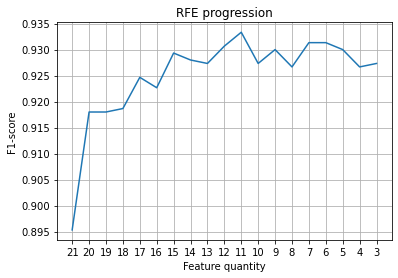

In [113]:
mean_score_result = rfe_feature_selector.cv_results_["mean_test_score"]
feature_quantity = X.shape[1]
min_feature_quantity = feature_quantity - mean_score_result.shape[0]
feature_quantity_progression = [str(x) for x in range(feature_quantity,min_feature_quantity,-1)]

plt.plot(feature_quantity_progression,mean_score_result)
plt.title("RFE progression")
plt.xlabel("Feature quantity")
plt.ylabel("F1-score")
plt.grid(True)
plt.show()

In [122]:
rfe_feature_selector.ranking_

array([1, 1, 5, 1, 6, 9, 1, 1, 1, 1, 1, 1, 1, 3, 4, 8, 1, 1, 1, 2, 7])

In [110]:
selected_features = rfe_feature_selector.get_feature_names_out()
X,y = df_train[selected_features],df_train[target].values.ravel()

scores = cross_val_score(estimator=RandomForestClassifier(min_samples_split=3, min_samples_leaf=3,random_state=42),
                cv = StratifiedKFold(n_splits=5,random_state=42,shuffle=True),
                X=X,y=y,
                scoring=f1_score_micro,
                n_jobs=-1)
scores.mean()

0.9313333333333335